### Desafío - Análisis lineal discriminante

**Nombre alumno:** Julio Valdés

Profesor: Gabriel Tamayo L.

Generación: G5

* Para poder realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad.
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
* Una vez terminado el desafío, comprime la carpeta y sube el .zip a la sección correspondiente.


#### Descripción
Trabajaremos con una base de datos sobre clientes morosos de un banco. Dentro de ésta se registran las siguientes observaciones:
* default : Variable Binaria. Registra si el cliente entró en morosidad o no.
* income : Ingreso promedio declarado por el cliente.
* balance : total del sando en la cuenta de crédito.
* student : Variable binaria. Registra si el cliente es estudiante o no.

### Ejercicio 1: Preparación de ambiente de trabajo
* Importe los módulos básicos para el análisis de datos.
* Importe las clases LabelEncoder , StandardScaler y LabelBinarizer de preprocessing
* Importe las funciones train_test_split y cross_val_score de model_selection
* Importe la función classification_report de metrics
* Importe las clases LinearDiscriminantAnalysis y QuadraticDiscriminantAnalysis .
* Agregue la base de datos en el ambiente de trabajo.
* Inspeccione la distribución de cada atributo

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-darkgrid')

df = pd.read_csv('default_credit.csv').drop('index', axis=1)
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
default    10000 non-null object
student    10000 non-null object
balance    10000 non-null float64
income     10000 non-null float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


In [4]:
df.describe()

,balance,income
count,10000.000000,10000.000000
mean,835.374886,33516.981876
std,483.714985,13336.639563
min,0.000000,771.967729
25%,481.731105,21340.462903
50%,823.636973,34552.644802
75%,1166.308386,43807.729272
max,2654.322576,73554.233495


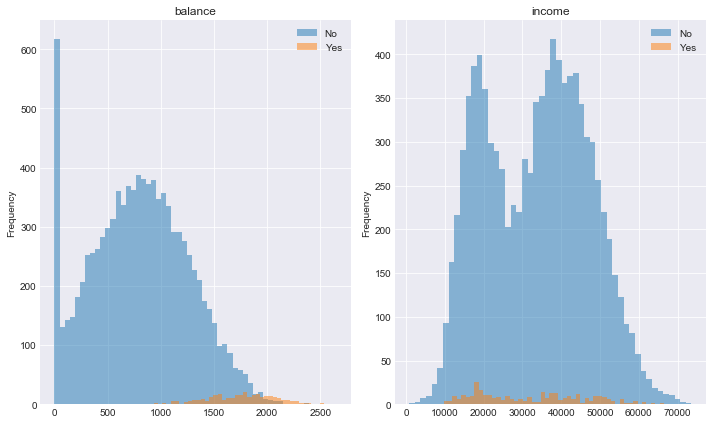

In [5]:
plt.figure(figsize=(10, 6))
for n, i in enumerate(['balance', 'income']):
    plt.subplot(1, 2, n + 1)
    df.groupby('default')[i].plot(kind='hist', alpha=.5, bins=50)
    plt.legend(df['default'].unique())
    plt.title(i)
    plt.tight_layout()

In [6]:
df['default'].value_counts('%')

No     0.9667
Yes    0.0333
Name: default, dtype: float64

In [7]:
df['student'].value_counts('%')

No     0.7056
Yes    0.2944
Name: student, dtype: float64

### Ejercicio 2: Modelo base
* Recuerde que los modelos de sklearn no soportan datos que no sean numéricos. Transforme los atributos pertinentes con LabelEncoder .
* Genere muestras de validación y entrenamiento, reservando un 33% de los datos como validación.
* Genere un modelo con LinearDiscriminantAnalysis sin modificar los hiperparámetros.
* Genere métricas de evaluación utilizando classification_report .
* Comente sobre cuál es el desempeño del modelo en cada clase, así como en general.

In [8]:
label_encoder = LabelEncoder()
df['default_bin'] = label_encoder.fit_transform(df['default'])
df['student_bin'] = label_encoder.fit_transform(df['student'])
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, ['balance', 'income', 'student_bin']], df['default_bin'], random_state=11238, test_size = 0.33)
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)
y_pred = lda_model.predict(X_test)

print("Probabilidades a priori\n", lda_model.priors_, "\n")
print("Medias de atributos en cada clase\n",
lda_model.means_.round(2), "\n")
print("Varianza explicada por cada discriminante\n",
lda_model.explained_variance_ratio_.round(2), "\n")
print("Coeficientes\n", lda_model.coef_)


Probabilidades a priori
 [0.96731343 0.03268657] 

Medias de atributos en cada clase
 [[8.036500e+02 3.340200e+04 2.900000e-01]
 [1.734750e+03 3.217489e+04 3.600000e-01]] 

Varianza explicada por cada discriminante
 [1.] 

Coeficientes
 [[ 4.65931873e-03 -7.50785395e-07 -6.46927932e-01]]


In [9]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3186
           1       0.72      0.25      0.38       114

   micro avg       0.97      0.97      0.97      3300
   macro avg       0.85      0.63      0.68      3300
weighted avg       0.97      0.97      0.96      3300



#### Comentarios
* Al analizar los indicadores se observa que la 'clase 0' presenta buenos resultado, no así la 'clase 1' que presenta un recall y f1-score bastante bajos. Esto puede ser por la baja cantidad de muestras de entrenamiento con que se cuenta para esta clase. En términos generales los resultados son buenos para los indicadores.

### Ejercicio 3: Refactorización 1 - información a priori
* Dado que trabajamos con modelos generativos, podemos incluír información exógena. Para este caso agregaremos dos distribuciones:
    * Asumamos que hay un 50/50 de morosos y no morosos.
    * Asumamos que hay un 60/40 de morosos y no morosos.
* Por cada modelo, reporte las métricas de clasificación.

#### Modelo 1: 50/50 de morosos y no morosos

In [10]:
lda_model_1 = LinearDiscriminantAnalysis(priors = [0.5, 0.5])
lda_model_1.fit(X_train, y_train)
y_pred_1 = lda_model_1.predict(X_test)

print("Probabilidades a priori\n", lda_model_1.priors_, "\n")
print("Medias de atributos en cada clase\n",
lda_model_1.means_.round(2), "\n")
print("Varianza explicada por cada discriminante\n",
lda_model_1.explained_variance_ratio_.round(2), "\n")
print("Coeficientes\n", lda_model_1.coef_)

Probabilidades a priori
 [0.5 0.5] 

Medias de atributos en cada clase
 [[8.036500e+02 3.340200e+04 2.900000e-01]
 [1.734750e+03 3.217489e+04 3.600000e-01]] 

Varianza explicada por cada discriminante
 [1.] 

Coeficientes
 [[ 4.65931873e-03 -7.50785395e-07 -6.46927932e-01]]


In [11]:
print(classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      3186
           1       0.17      0.92      0.29       114

   micro avg       0.84      0.84      0.84      3300
   macro avg       0.58      0.88      0.60      3300
weighted avg       0.97      0.84      0.89      3300



#### Modelo 1: 60/40 de morosos y no morosos

In [12]:
lda_model_2 = LinearDiscriminantAnalysis(priors = [0.6, 0.4])
lda_model_2.fit(X_train, y_train)
y_pred_2 = lda_model_2.predict(X_test)

print("Probabilidades a priori\n", lda_model_2.priors_, "\n")
print("Medias de atributos en cada clase\n",
lda_model_2.means_.round(2), "\n")
print("Varianza explicada por cada discriminante\n",
lda_model_2.explained_variance_ratio_.round(2), "\n")
print("Coeficientes\n", lda_model_2.coef_)

Probabilidades a priori
 [0.6 0.4] 

Medias de atributos en cada clase
 [[8.036500e+02 3.340200e+04 2.900000e-01]
 [1.734750e+03 3.217489e+04 3.600000e-01]] 

Varianza explicada por cada discriminante
 [1.] 

Coeficientes
 [[ 4.65931873e-03 -7.50785395e-07 -6.46927932e-01]]


In [13]:
print(classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94      3186
           1       0.21      0.88      0.34       114

   micro avg       0.88      0.88      0.88      3300
   macro avg       0.60      0.88      0.64      3300
weighted avg       0.97      0.88      0.92      3300



### Ejercicio 4: Refactorización 2 - oversampling
Digresión: Synthetic Over(Under)Sampling

* Por lo general podemos intentar aliviar el problema del desbalance de clases mediante la ponderación dentro del algoritmo. Otra alternativa es el muestreo con reemplazo dentro de los conjuntos de entrenamiento. Estos métodos clásicos se conocen como Oversampling cuando repetimos registros aleatorios de la clase minoritaria, y Undersampling cuando eliminamos aleatoriamente registros de la clase mayoritaria.
* Un contratiempo de estos métodos clásicos es que pueden replicar información sesgada que afecte el desempeño de generalización del modelo. Si los datos son malos, estaremos replicando estas fallas.
* Otra solución es generar ejemplos de entrenamiento sintéticos mediante el entrenamiento de ejemplos de la clase minoritaria. A grandes rasgos la solución funciona de la siguiente forma: 
    * En función a un subconjunto de datos correspondientes a la case minoritaria, entrenamos algún modelo no supervisado o generativo como Naive Bayes, KMeans o KNearestNeighbors para generar representaciones sintéticas de los datos en el espacio de atributos de la clase específica mediante 
    
    $\mathbf{x}_{nuevoEjemplo} = \mathbf{x}_{i} + \lambda (\mathbf{x}_{zi} - \mathbf{x}_{i})$ 
    
    donde 
    $\mathbf{x}_{zi}$ 
    es un ejemplo de entrenamiento de la clase minoritaria y $\lambda$ es un parámetro de interpolación aleatorio $\lambda \sim \textsf{Uniforme}(0, 1)$.
    
    
* Uno de los problemas más graves de esta base de datos, es el fuerte desbalance entre clases. Ahora generaremos observaciones sintéticas mediante SMOTE (Synthetic Minority Oversampling Technique). Para ello, debemos agregar el paquete a nuestro ambiente virtual. En nuestro terminal agregamos conda install -c conda-forge imbalanced-learn. Incorpore SMOTE en el ambiente de trabajo con la siguiente sintáxis from imblearn.over_sampling import SMOTE.

* Para implementar oversampling, debemos generar nuevos objetos que representan nuestra muestra de entrenamiento incrementada artificialmente. Para ello implemente la siguiente sintáxis:

```python
from imblearn.over_sampling import SMOTE
# Instanciamos la clase
oversampler = SMOTE(random_state=11238, ratio='minority')
# generamos el eversampling de la matriz de entrenamiento y
X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train, y_train)
```

* Vuelva a entrenar el modelo con los datos aumentados de forma artificial y comente sobre su desempeño.

In [14]:
from imblearn.over_sampling import SMOTE
oversampler = SMOTE(random_state=11238, ratio='minority')
X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train, y_train)

In [15]:
lda_model_3 = LinearDiscriminantAnalysis()
lda_model_3.fit(X_train_oversamp, y_train_oversamp)
y_pred_3 = lda_model_3.predict(X_test)

print("Probabilidades a priori\n", lda_model_3.priors_, "\n")
print("Medias de atributos en cada clase\n",
lda_model_3.means_.round(2), "\n")
print("Varianza explicada por cada discriminante\n",
lda_model_3.explained_variance_ratio_.round(2), "\n")
print("Coeficientes\n", lda_model_3.coef_)

Probabilidades a priori
 [0.5 0.5] 

Medias de atributos en cada clase
 [[8.036500e+02 3.340200e+04 2.900000e-01]
 [1.739320e+03 3.219938e+04 3.500000e-01]] 

Varianza explicada por cada discriminante
 [1.] 

Coeficientes
 [[ 6.84324737e-03 -6.99296454e-06 -1.16771929e+00]]


In [16]:
print(classification_report(y_test, y_pred_3))

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      3186
           1       0.17      0.92      0.29       114

   micro avg       0.84      0.84      0.84      3300
   macro avg       0.58      0.88      0.60      3300
weighted avg       0.97      0.84      0.89      3300



### Ejercicio 5: Refactorización 3 - QDA

* Por último, implemente un modelo QuadraticDiscriminantAnalysis con los datos aumentados artificialmente. Genere las métricas de desempeño.
* Comente a grandes rasgos sobre el mejor modelo en su capacidad predictiva.

In [23]:
qda_model = QuadraticDiscriminantAnalysis().fit(X_train_oversamp, y_train_oversamp)
qda_class_pred = qda_model.predict(X_test)
print(classification_report(y_test, qda_class_pred))

              precision    recall  f1-score   support

           0       1.00      0.87      0.93      3186
           1       0.20      0.89      0.32       114

   micro avg       0.87      0.87      0.87      3300
   macro avg       0.60      0.88      0.63      3300
weighted avg       0.97      0.87      0.91      3300



#### Comentarios
* El modelo que presenta mejores indicadores de acuerdo a las métricas entregadas por classification_report es el primero, que considera un modelo LDA sin especificar los priors. Esto se puede observar al comparar el F1 por clase y en general.